In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
# Load and inspect data
subscription = pd.read_csv('subscription.csv')

In [3]:
subscription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
user_id                      500000 non-null int64
subscription_signup_date     500000 non-null object
subscription_monthly_cost    500000 non-null int64
country                      500000 non-null object
source                       500000 non-null object
billing_cycles               500000 non-null int64
is_active                    500000 non-null int64
dtypes: int64(4), object(3)
memory usage: 26.7+ MB


In [4]:
subscription.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


In [5]:
subscription.subscription_monthly_cost.unique()

array([29, 49, 99], dtype=int64)

In [6]:
subscription.country.unique()

array(['Spain', 'France', 'Germany', 'China', 'UK', 'US', 'India', 'Italy'], dtype=object)

In [7]:
subscription.source.unique()

array(['ads', 'seo', 'friend_referral'], dtype=object)

In [8]:
# Use the Kaplan-Meier estimator to estimate the survival function of subscribers
subscription['churned'] = subscription.is_active.apply(lambda x: 1 if x == 0 else 0)
kmf = KaplanMeierFitter() 
kmf.fit(durations = subscription.billing_cycles, event_observed = subscription.churned)

<lifelines.KaplanMeierFitter: fitted with 500000 observations, 49999 censored>

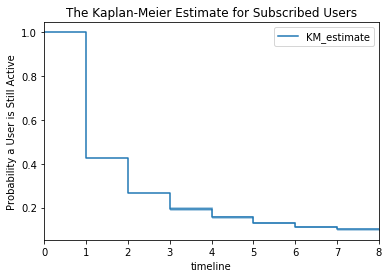

In [9]:
# Plot the survival curve
kmf.plot()
plt.title("The Kaplan-Meier Estimate for Subscribed Users")
plt.ylabel("Probability a User is Still Active")

In [10]:
# What's the median life time of a subscriber?
kmf.median_

1.0

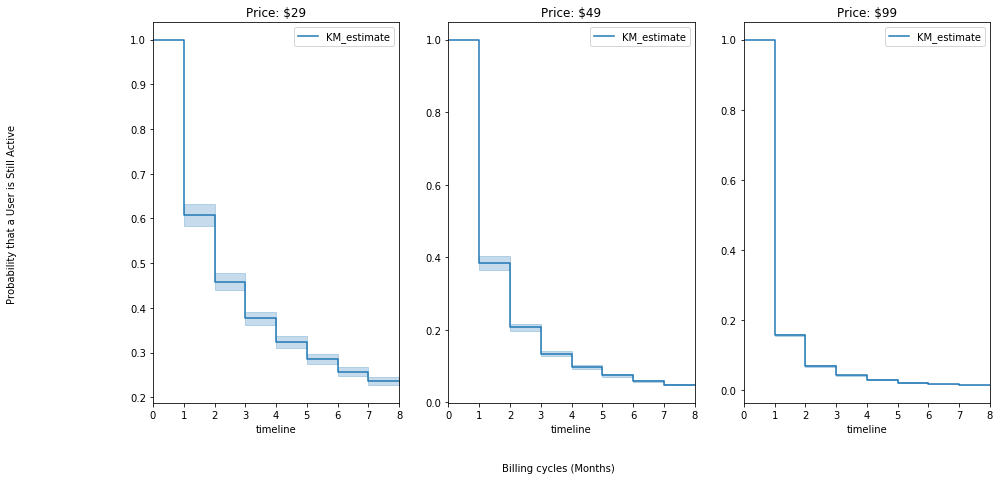

In [11]:
# Plot survival curves by price point
fig, axes = plt.subplots(1, 3,  figsize=(15,7))
price_points = [29, 49, 99]
for i in range(3):
    df = subscription[subscription.subscription_monthly_cost == price_points[i]]
    kmf.fit(durations=df.billing_cycles, event_observed= df.churned)
    kmf.plot(ax = axes[i],label = price_points[i])
    axes[i].set_title("Price: $"+str(price_points[i]))
fig.text(0.5, -0.01, "Billing cycles (Months)", ha="center")
fig.text(-0.01, 0.5, "Probability that a User is Still Active", 
         va="center", rotation="vertical")

**Price definitely has a huge impact on the retention rate. We see higher churn rates during the beginning of the program with higher prices, but they tend to drop and stabilize very quickly. We see less churn with lower priced subcriptions, but the churn rates take more time to stabilize.**

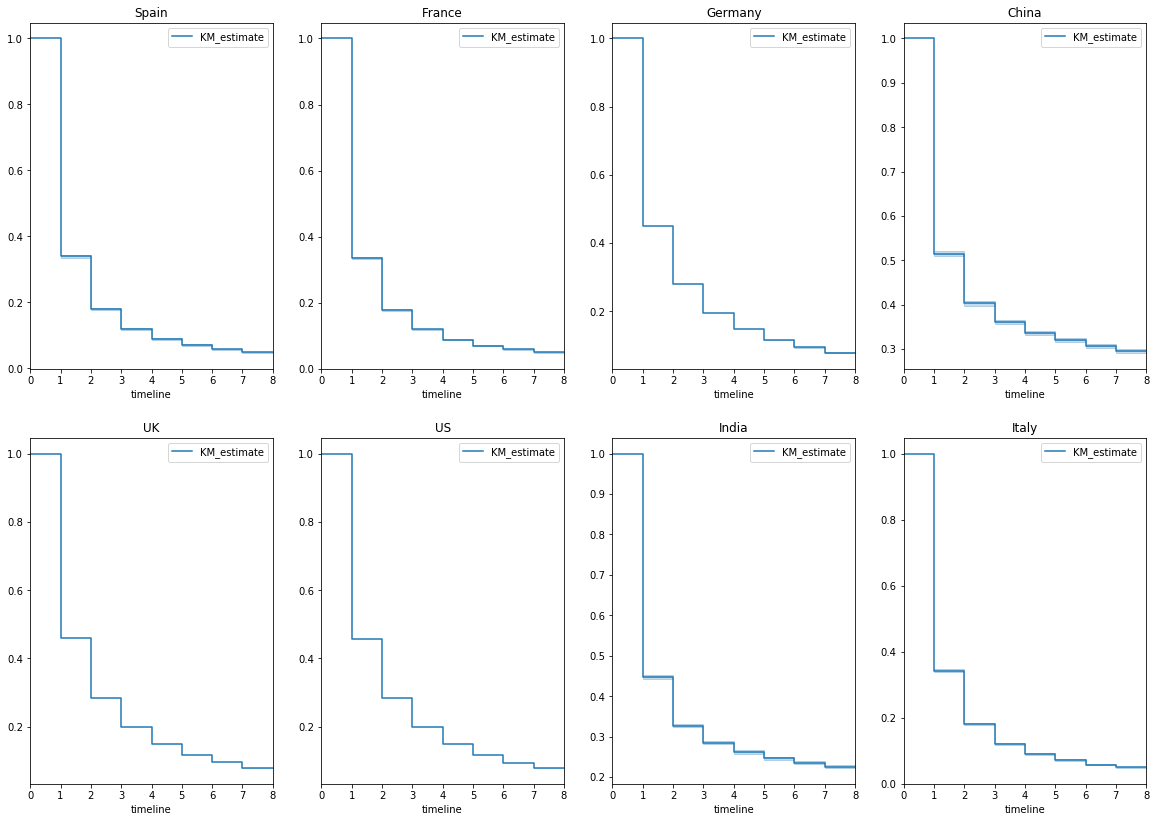

In [12]:
# Plot survival curves by country
fig, axes = plt.subplots(2, 4,  figsize=(20,14))
countries = ['Spain', 'France', 'Germany', 'China', 'UK', 'US', 'India', 'Italy']
for country, ax in zip(countries, axes.flatten()):
    df = subscription[subscription.country == country]
    kmf.fit(durations=df.billing_cycles, event_observed= df.churned)
    kmf.plot(ax = ax)
    ax.set_title(country)

**We can see significantly higher retention rates among users in China and India than users in other countries.**

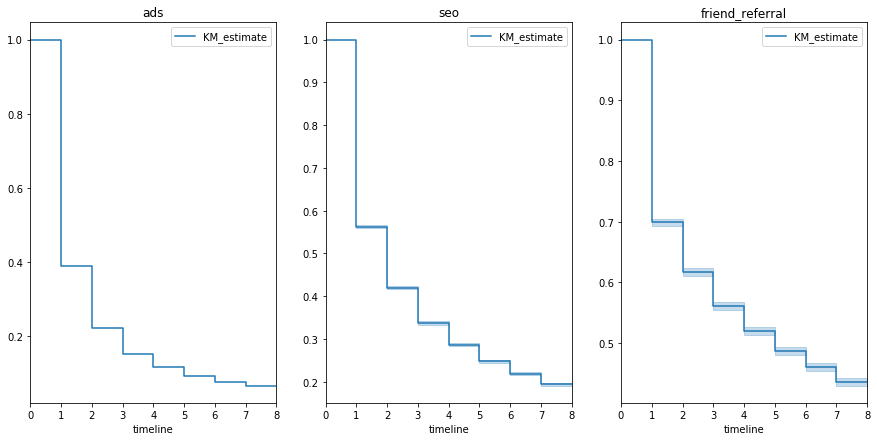

In [13]:
# Plot survival curves by source
fig, axes = plt.subplots(1, 3,  figsize=(15,7))
sources = ['ads', 'seo', 'friend_referral']
for source, ax in zip(sources, axes.flatten()):
    df = subscription[subscription.source == source]
    kmf.fit(durations=df.billing_cycles, event_observed= df.churned)
    kmf.plot(ax = ax)
    ax.set_title(source)

**We see a greater customer retention from friend referrals.**

In [14]:
# View the survival tables for each price point
df = subscription[subscription.subscription_monthly_cost == 29]
kmf.fit(durations=df.billing_cycles, event_observed= df.churned)
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,146362,146362
1.0,57441,57441,0,0,146362
2.0,21818,21818,0,0,88921
3.0,12037,12037,0,0,67103
4.0,7787,7787,0,0,55066
5.0,5505,5505,0,0,47279
6.0,4136,4136,0,0,41774
7.0,3111,3111,0,0,37638
8.0,34527,0,34527,0,34527


**There were no inactive subscriptions during the month of August. Assuming that this behavior continues, we should expect 23% of the $29 subscriptions to still be active by the end of the year.**

In [15]:
df = subscription[subscription.subscription_monthly_cost == 49]
kmf.fit(durations=df.billing_cycles, event_observed= df.churned)
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,300397,300397
1.0,185145,185145,0,0,300397
2.0,53296,53296,0,0,115252
3.0,21690,21690,0,0,61956
4.0,11288,11288,0,0,40266
5.0,6727,6727,0,0,28978
6.0,4405,4405,0,0,22251
7.0,3173,3173,0,0,17846
8.0,14673,0,14673,0,14673


**There were no inactive subscriptions during the month of August. Assuming that this behavior continues, we should expect 4% of the $49 subscriptions to still be active by the end of the year.**

In [16]:
df = subscription[subscription.subscription_monthly_cost == 99]
kmf.fit(durations=df.billing_cycles, event_observed= df.churned)
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,53241,53241
1.0,44788,44788,0,0,53241
2.0,4724,4724,0,0,8453
3.0,1471,1471,0,0,3729
4.0,678,678,0,0,2258
5.0,399,399,0,0,1580
6.0,226,226,0,0,1181
7.0,156,156,0,0,955
8.0,799,0,799,0,799


**There were no inactive subscriptions during the month of August. Assuming that this behavior continues, we should expect 1.5% of the $99 subscriptions to still be active by the end of the year.**

**To improve company revenue, I recommend:**  
- **Conduct user experience research on the first month of subscription. Over 50% of cancellations occur during the 1st month of the subscription. Improving user experience during the first month will dramatically improve retention rate.**
- **Incentivize users who refer their friends by offering a prize or discount on monthly subscription.**